In [1]:
# installing packages
import sys
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "plotly_dark"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import optuna
import imblearn as imb
from collections import Counter

from sklearn.metrics import (PrecisionRecallDisplay, precision_score,
recall_score,confusion_matrix,f1_score)
from sklearn.model_selection import train_test_split
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance)


In [12]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/testing_data.csv")
target="bankruptcy"
data = pd.concat([training_data,testing_data],axis=0).reset_index(drop=True)
print("Original Data Shape",data.shape)

data["company type"] = data["company type"].astype("category")

holdout=data.iloc[:50,:]
data = data.iloc[50:,:] 
print("Shape after dropping",data.shape)
X,y = data.drop(target,axis=1),data[target]

#Holdout
print("Shape of holdout",holdout.shape)
print(Counter(holdout[target]))

Original Data Shape (6811, 96)
Shape after dropping (6761, 96)
Shape of holdout (50, 96)
Counter({0: 47, 1: 3})


In [13]:
sampling_strategy=False
if sampling_strategy:
    # define oversampling strategy
    # oversample = RandomOverSampler(sampling_strategy='minority')
    oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.06)
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    print(Counter(y_over))
else :
    X_over = X.copy(deep=True)
    y_over = y.copy(deep=True)
    print(Counter(y_over))

Counter({0: 6545, 1: 216})


In [4]:
X_train,X_test,y_train,y_test = \
    train_test_split(X_over,y_over,test_size=0.3, stratify=y,random_state=42)

In [5]:
# X_train,y_train = training_data.drop("bankruptcy",axis = 1),training_data['bankruptcy']
# X_test,y_test = testing_data.drop("bankruptcy",axis = 1),testing_data['bankruptcy']
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4581, 1: 151})
Counter({0: 1964, 1: 65})


### Benchmark Model

Precision_Score: 0.05893019038984588,                Recall Score: 0.4304635761589404,                f1_score: 0.10366826156299841,
                confusion matrix: 
[[3543 1038]
 [  86   65]]
                classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4581
           1       0.06      0.43      0.10       151

    accuracy                           0.76      4732
   macro avg       0.52      0.60      0.48      4732
weighted avg       0.95      0.76      0.84      4732

Precision_Score: 0.05818965517241379,                Recall Score: 0.4153846153846154,                f1_score: 0.10207939508506615,
                confusion matrix: 
[[1527  437]
 [  38   27]]
                classification report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1964
           1       0.06      0.42      0.10        65

    accuracy                           

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


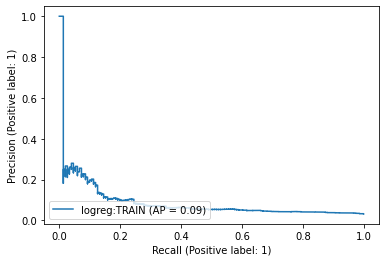

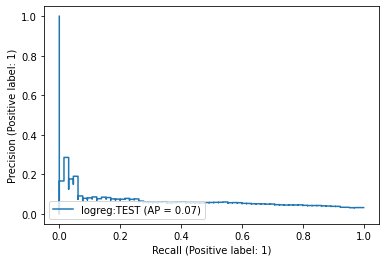

In [6]:
ohe = OneHotEncoder()
cat_cols = ["company type"]
X_train_ohe = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

X_train_lr = X_train.drop(cat_cols,axis=1).copy(deep=True)
X_test_lr = X_test.drop(cat_cols,axis=1).copy(deep=True)

X_train_lr[ohe.categories_[0]] = X_train_ohe
X_test_lr[ohe.categories_[0]] = X_test_ohe


benchmark_mod = LogisticRegression(class_weight="balanced")
benchmark_mod.fit(X_train_lr,y_train)

pred_train_lr = benchmark_mod.predict_proba(X_train_lr)
pred_test_lr = benchmark_mod.predict_proba(X_test_lr)

model_performance(y_pred=pred_train_lr,y_true=y_train,threshold=0.5,
title="logreg:TRAIN",model_type="logreg")

model_performance(y_pred=pred_test_lr,y_true=y_test,threshold=0.5,
title="logreg:TEST",model_type="logreg")

In [13]:
# bbc = imb.ensemble.BalancedRandomForestClassifier(class_weight={0: 4581, 1: 151}).fit(X_train_lr,y_train)
# pred_train_bbc = bbc.predict_proba(X_train_lr)
# pred_test_bbc = bbc.predict_proba(X_test_lr)

# model_performance(y_pred=pred_train_bbc,y_true=y_train,threshold=0.5,
# title="bbc:TRAIN",model_type="bbc")

# model_performance(y_pred=pred_test_bbc,y_true=y_test,threshold=0.5,
# title="bbc:TEST",model_type="bbc")


In [ ]:

def full_data(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,20),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli","MVS"]
        )
    }

    if param["objective"] == "LogLoss":
        "scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1],
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, 
    early_stopping_rounds=10,cat_features=["company type"]
    )

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [ ]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(full_data, n_trials=50, timeout=600)

In [ ]:
print("Number of finished trials: {}".format(len(study1.trials)))

print("Best trial:")
trial = study1.best_trial

print("  Value: {}".format(trial.value))

best_params={}
print("  Params: ")
for key, value in trial.params.items():
    best_params[key]=value
print(best_params)

In [ ]:
extra_params = {"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    "auto_class_weights":"Balanced"
    }
best_params = {**best_params, **extra_params}


In [ ]:
mod2 = CatBoostClassifier(**best_params)

mod2.fit(X_train,y_train)

# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

In [ ]:
model_performance(y_pred=pred_train_cat,y_true=y_train,threshold=0.5,
title="catboost:TRAIN",model_type="catboost")

model_performance(y_pred=pred_test_cat,y_true=y_test,threshold=0.5,
title="catboost:TEST",model_type="catboost")


In [ ]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)

In [ ]:
top=60
importance_mod2 = get_shap_feat_importance(shap_values2,X_train)
importance_topk = importance_mod2[importance_mod2["shap_importance"]>0][:top]
best_feat = importance_topk.features.values

In [ ]:
fig = go.Figure([go.Bar(x=importance_topk.features, y=importance_topk.shap_importance)])
fig.update_layout(width=1200, height=500,xaxis_tickangle=-90, title="topk SHAP Importance")


In [ ]:
if X_train[best_feat].select_dtypes(exclude=np.number).shape[1]>0:
    print(f"categorical feature detected")
else: 
    print(f"NO categorical feature detected")

In [ ]:

def obj_best_feat(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,20),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli","MVS"]
        )
    }

    # if param["objective"] == "LogLoss":
    #     #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1],
    #     param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train[best_feat], y_train, eval_set=[(X_test[best_feat], y_test)], verbose=0, 
    early_stopping_rounds=10#,cat_features=["company type"]
    )

    preds = gbm.predict(X_test[best_feat])
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [ ]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(obj_best_feat, n_trials=50, timeout=600)

In [ ]:
print("Number of finished trials: {}".format(len(study2.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial2.value))

best_params2={}
print("  Params: ")
for key, value in trial2.params.items():
    best_params2[key]=value
print(best_params2)

In [ ]:
extra_params = {
    #"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    #"auto_class_weights":"Balanced"
    }

best_params2 = {**best_params2, **extra_params}

In [ ]:
mod3 = CatBoostClassifier(**best_params2)

mod3.fit(X_train[best_feat],y_train)

# Get predicted probabilities for each class
pred_train_cat3 = mod3.predict_proba(X_train[best_feat])
pred_test_cat3 = mod3.predict_proba(X_test[best_feat])

In [ ]:
model_performance(y_pred=pred_train_cat3,y_true=y_train,threshold=0.5,
title="catboost:TRAIN_BEST_FEAT",model_type="catboost")

model_performance(y_pred=pred_test_cat3,y_true=y_test,threshold=0.5,
title="catboost:TEST_BEST_FEAT",model_type="catboost")


In [ ]:
holdout_df = holdout.drop(target,axis = 1)[best_feat]
pred_holdout_cat = mod3.predict_proba(holdout_df)
model_performance(y_pred=pred_holdout_cat,y_true=holdout[target],threshold=0.5,
title="catboost:HOLDOUT",model_type="catboost")
